# Introduction

The purpose of this notebook is to explore the consistency question of sublevel sets defined on random graphs, as the scaling parameter goes to zero. That is, suppose we have a sequence of random geometric graphs $\mathcal{G}_n$, defined by sampling an increasing number of points uniformly at random from a domain $\mathcal{D}$ in Euclidean space $\mathbb{R}^d$. 

### Sublevel filtrations on the domain
Consider a suitably well behaved function $f$ defined as $f:\mathcal{D} \rightarrow \mathbb{R}.$ We can define the sublevel set filtration, which we refer to as the *domain sublevel filtration* of the function $f:\mathcal{D} \rightarrow \mathbb{R}$ on the domain $\mathcal{D}$ as the filtered simplicial complex  $\lbrace S_r \hookrightarrow S_t\rbrace_{r \leq t; r, t \in \mathbb{R}}$ where the sets $S_r$ are the sublevel sets of the function $f^{-1}((-\infty,r]).$

We're interested in the persistent homology of this filtered simplicial complex, in particular $H_0$ persistent homology, which measures the birth and death sequence of connected components of these sublevel sets.

### Sublevel filtrations on graphs.
We can also define a similar construction on graphs. Given a graph $\mathcal{G},$ with a function $g$ defined on its vertices, define the *graph sublevel set* $GS_r$ as the subgraph whose vertices lie in the set $\lbrace v: f(v) \leq r\rbrace.$ Now define the *graph sublevel filtration* as the filtered simplicial complex given by $\lbrace GS_r \hookrightarrow GS_t \rbrace_{r \leq t.}$ We can also define the $H_0$ persistent homology of this filtered simplicial complex.

### Consistency

The question we want to answer is the following: Suppose we have a sequence of random geometric graphs $\mathcal{G}_n$ defined in the domain $\mathcal{D},$ with the function $f$ defined on their vertices. **How close are the persistent homologies (measuring in bottleneck distance) of the graph sublevel filtration of $\mathcal{G}_n$ and the domain sublevel filtration, as $n \rightarrow \infty$?**

There are two variants of this question. We can either consider the limit of the random geometric graphs where the connectivity parameter stays constant, or one in which the connectivity parameter $\epsilon_n$ scales to zero as $n \rightarrow.$ This would allow us some idea of how to pick the connectivity parameter $\epsilon$ as a function of the number of points sampled (we also see similar results in the literature on the consistency of th graph Laplacian.) The type of result that would be interesting would be some distance / stability type result, or also a limit type result showing that the bottleneck distance is small.

# Why?

This is an approximation result that tells us we can approximate persistent homology of the sublevel sets of the global function using a network of local sensors. We use the sublevel set of the function to capture global periodicity (up to isometry) of the function $f.$ This is done by analyzing the time series of bottleneck diagrams and their sliding window point cloud (which we can metrize using bottleneck distance).

The same pipeline can be utilized to capture periodicity of a general dynamic network.

# Related Literature





## Simulation Setup

We have a proposed proof of this consistency result, with probability one, as $n \rightarrow \infty$ with constant connectivity parameter $\epsilon$. The bottleneck distance will be bounded by $\epsilon.$

We can simulate this result in the plane, say on a 2D grid $[0,1]^2,$ with a bumpy function $f$ defined on it. 

- Identify the bottleneck diagram of the domain sublevel filtration function $f$ on $[0,1]^2.$
- Define a sequence of random geometric graphs $\mathcal{G}_n$ defined on $[0,1]^2,$ with different scaling parameters $\epsilon_n$.
- Compute the bottleneck diagram of the graph sublevel filtrations $(\mathcal{G}_n, f).$ Visualize convergence of the bottleneck diagram of the graph sublevel fitlrations to that of the domain sublevel filtration.


What's one way to do this? Define a 2D Gaussian process / random Gaussian field on the plane. 

## Further Simulation Setups

We can do this with 

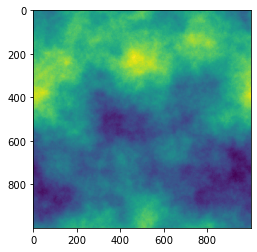

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fftIndgen(n):
    # padding
    a = list(range(0, int(n/2)+1))
    b = list(range(1, int(n/2)))
    b = b[::-1]
    b = [-i for i in b]
    return a + b

# uses FFT to generate. What covariance matrix is. being. used?
def gaussian_random_field(Pk = lambda k : k**-3.0, size = 100):
    def Pk2(kx, ky):
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = Pk2(kx, ky)
    return np.fft.ifft2(noise * amplitude)

for alpha in [-3.5]:
    out = gaussian_random_field(Pk = lambda k: k**alpha, size=1000)
    plt.figure()
    plt.imshow(out.real, interpolation='none')

In [2]:
# Use the above as a probability distribution on cubes to generate points on the grid

In [3]:
#function on [0,1]
probs = out.real - out.real.min() # do we need to make this smoother?
probs = probs / probs.sum()

In [4]:
samples = np.random.choice(len(probs.flatten()),100000, p = probs.flatten())
samples = np.array(list(zip((samples/1000).astype(int), samples%1000))).astype(np.float64)

# jitter the coordinates slightly
samples += np.random.uniform(0.0, 1.0, size = samples.shape)

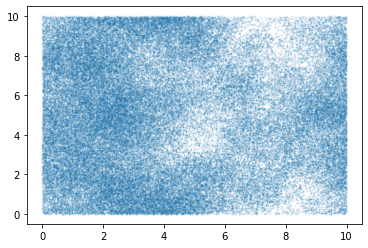

In [5]:
plt.scatter(samples[:,0]/100,samples[:,1]/100,s = 1, alpha = 0.1) # let's work on a 10 x 10 grid

In [6]:
samples = np.random.uniform(0.0,1.0, size = (10,2))

In [7]:
# define a sequence of random geometric graphs whose function values come from the function above.

# Can get the bottleneck distance via our own tools - specify birth time of the vertices themselves, which then allows us 
# to specify birth times of every edge as the max of the vertices. Then calculate zero dimensional persistence.

# another approach is to generate KDE of random points in the grid. Can try to approximate a random field, or can simply
# sample a small number of points uniformly and blow up using the KDE
from sklearn.neighbors import KernelDensity
import gudhi as gd

# sample points randomly from the plane - has to be nonuniform density though;

xval = np.arange(0,1,0.001)
yval = np.arange(0,1,0.001)
nx = len(xval)
ny = len(yval)


kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(samples)
positions = np.array([[u,v] for u in xval for v in yval ])

filt_values =  - kde.score_samples(X= positions) # might need to set minimum to zero or something; the minimum does
# super level set filtrations

# compute a cubical complex using these function
cc_density_crater= gd.CubicalComplex(dimensions= [nx ,ny],
                                    top_dimensional_cells =filt_values)

In [8]:
filt_values.min()

-1.937269617564275

In [9]:
filt_values.reshape((-1,1))

array([[ 2.55412036],
       [ 2.50988859],
       [ 2.46605682],
       ...,
       [17.01252568],
       [17.13173738],
       [17.25134909]])

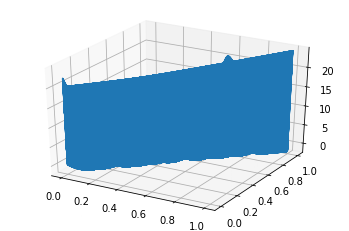

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X = positions,Y = positions, Z = filt_values.reshape(-1,1))

In [11]:
# Get the persistence diagram - just call the persistence function on it. 
cc_density_crater.persistence()
true_pers = cc_density_crater.persistence_intervals_in_dimension(0) # matches the number of points we sample!

In [12]:
true_pers

array([[-1.93724754, -1.87956083],
       [-1.85384593, -1.07004064],
       [-1.85262656, -0.94240588],
       [-1.85213596, -0.83304133],
       [-1.85097958,  1.5847825 ],
       [-1.85096545,  1.91938885],
       [-1.85097241,  2.48565297],
       [-1.85263609,  2.71810112],
       [-1.8547868 ,  9.85204126],
       [-1.93726962,         inf]])

## Sample random geometric graphs and calculate their persistence diagrams

In [14]:
from __future__ import division
import numpy as np
import sys
import os
from scipy.spatial.distance import squareform
from ripser import ripser
sys.path.append('../src/')
import graph_fns as gf
import persistence_fns as pf
import sliding_window_fns as sw
import rgg_utils as rgg

from sklearn import manifold
from importlib import reload
reload(rgg)
reload(pf)

<module 'persistence_fns' from '../shared_scripts/persistence_fns.py'>

In [15]:
# initialize the points first, calculate their values using the kde estimator above
rgg_points = np.random.uniform(0,1,(10000000,2))
vals = -kde.score_samples(X = rgg_points)

In [31]:
barcodes = []
for i in range(40):
#for i in [15]:
    print(i)
    pts = rgg_points[:(400*i),:]
    n = pts.shape[0]
    
    epsilon = (np.log(n)/(np.pi*n))**0.4 # can also make this scale with n
    
    node_wts =vals[:(400*i)]# pass this through the kernel function
    birthtimes = rgg.get_rgg_birthtime_matrix(pts, epsilon, distance_func = 'Euclidean') 

    # get the filtration birthtimes, compute persistence
    filt_matrix = pf.get_filtration(node_wts, birthtimes)

    barcodes.append(pf.get_rips_complex(filt_matrix))

0
1
2
3


<ipython-input-31-be3b17418d20>:8: RuntimeWarning: divide by zero encountered in log
  epsilon = (np.log(n)/(np.pi*n))**0.4 # can also make this scale with n


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


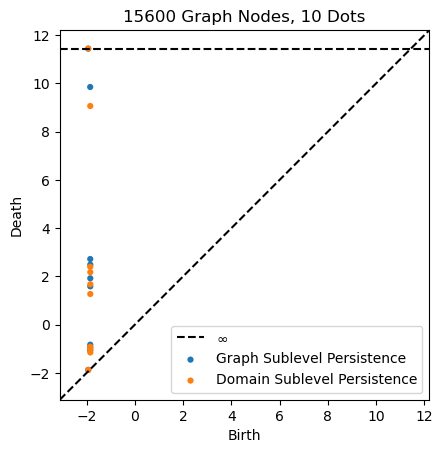

In [32]:
# make another video?
#
from persim import plot_diagrams

for i,dgm in enumerate(barcodes):
    
    # plot graph side by side  
    plt.clf()
    plt.subplot(111)
    
    
    plot_diagrams([np.array(true_pers),dgm] , labels=['Graph Sublevel Persistence','Domain Sublevel Persistence']) 

    
    plt.title("%i Graph Nodes, %i Dots"%((i)*400, dgm.shape[0]))
    plt.savefig("Images/ConsistencyExplorationConvergence/scalingEpsilon/%i.png"%i, bbox_inches='tight')
plt.show()

## Further questions

Does the same hold when using $k$-nearest neighbor graphs?

In [ ]:
barcodes = []
for i in range(40):
#for i in [15]:
    print(i)
    pts = rgg_points[:(400*i),:]
    n = pts.shape[0]
    
    epsilon = (np.log(n)/(np.pi*n))**0.4 # can also make this scale with n
    
    node_wts =vals[:(400*i)]# pass this through the kernel function
    birthtimes = rgg.get_rgg_birthtime_matrix(pts, epsilon, distance_func = 'Euclidean') 

    # get the filtration birthtimes, compute persistence
    filt_matrix = pf.get_filtration(node_wts, birthtimes)

    barcodes.append(pf.get_rips_complex(filt_matrix))